In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
from PIL import Image
from PIL import ImageDraw, ImageFont
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from datasets import load_dataset 
from datasets import load_metric
from datasets.features import ClassLabel
from transformers.data.data_collator import default_data_collator
from transformers import AutoProcessor
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForTokenClassification
DIR = os.getcwd()


In [2]:
!git config --global user.email "andre002wp@gmail.com"
!git config --global user.name "andre002wp"

In [3]:
dataset = load_dataset("Theivaprakasham/wildreceipt")
example = dataset["train"][0]
example["image_path"]
words, bboxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(bboxes)
print(ner_tags)

Found cached dataset wildreceipt (C:/Users/asus/.cache/huggingface/datasets/Theivaprakasham___wildreceipt/WildReceipt/1.0.0/643cda6d4cd0ff2e8d7ee57e4872c509b29060f1df957b5a59e66d9940b9594e)


  0%|          | 0/2 [00:00<?, ?it/s]

['SAFEWAY', 'TM', 'ATOREMGRTOMMILAZZO', '703-777-5833', 'THANKYOUFORSHOPPINGWITHUS!', 'GROCERY', 'BCCHOCCUPCAKES', 'ACNSPRYFRTSHAPE', 'Regprice', 'Cardsavings', 'MfrCpn', 'MultipliedCpn', 'DULCEDELECHECHE', 'Regprice', 'CardSavings', 'MfrCpn', 'MuitipliedCpn', 'MULTIGRAINCHEERIO', 'RegPrice', 'CardSavings', 'MfrCpn', 'MuitieliedCpn', 'PROGRESSOR&HSTK', 'RegPrice', 'CardSavings', 'REFRIG/FROZEN', '3.99', '.49', '3.79', '1.80-', '.75-', '.75-', '1.99', '4.19', '1.20-', '.50-', '.50-', '1.50', '3.99', '1.49-', '.50-', '.50-', '2.00', '2.69', '.69-', '1OIY', 'PLSBRYBSCTSANDWI', 'TOTINOSPZASTOFFE', 'RegPrice', '', '', '3.50', '3.49', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
[[343, 86, 585, 158], [655, 163, 671, 175], [334, 166, 520, 199], [566, 185, 675, 213], [360, 191, 635, 235], [452, 295, 525, 322], [296, 328, 458, 360], [293, 350, 477, 388], [291, 373, 371, 402], [289, 398, 411, 430], [286, 422, 358, 448], [284, 446, 428, 481], [283, 470, 468, 509], [280, 494, 363, 520], [278, 519, 402, 551]

## Exploration

In [31]:
dataset["train"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1267
})

In [32]:
dataset["test"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 472
})

## random test

In [4]:
def normalize_bbox(bbox, size):
    return [
        int(bbox[0] * 1000 / size[1]),
        int(bbox[1] * 1000 / size[0]),
        int(bbox[2] * 1000 / size[1]),
        int(bbox[3] * 1000 / size[0]),
    ]

def unnormalize_bbox(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

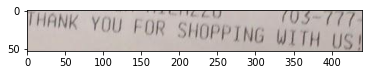

(1200, 1600, 3)


[576, 229, 1016, 282]

In [5]:
img_read = cv2.imread(example["image_path"])
img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
if img_read is None:
    raise Exception(f"Image {example['image_path']} not found")

xx = [360, 191, 635, 235]
xx = unnormalize_bbox(xx, img_read.shape)
plt.imshow(img_read[xx[1]:xx[3],xx[0]:xx[2]])
plt.show()
print(img_read.shape)
xx

## Continue

In [6]:
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [7]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features["ner_tags"].feature, ClassLabel):
    label_list = features["ner_tags"].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"]["ner_tags"])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [8]:
print(id2label)

{0: 'Ignore', 1: 'Store_name_value', 2: 'Store_name_key', 3: 'Store_addr_value', 4: 'Store_addr_key', 5: 'Tel_value', 6: 'Tel_key', 7: 'Date_value', 8: 'Date_key', 9: 'Time_value', 10: 'Time_key', 11: 'Prod_item_value', 12: 'Prod_item_key', 13: 'Prod_quantity_value', 14: 'Prod_quantity_key', 15: 'Prod_price_value', 16: 'Prod_price_key', 17: 'Subtotal_value', 18: 'Subtotal_key', 19: 'Tax_value', 20: 'Tax_key', 21: 'Tips_value', 22: 'Tips_key', 23: 'Total_value', 24: 'Total_key', 25: 'Others'}


In [9]:
dataset["train"][0]['words'] #words
dataset["train"][0]['bboxes'] #boxes
dataset["train"][0]['ner_tags'] #word_labels
dataset["train"].column_names

['id', 'words', 'bboxes', 'ner_tags', 'image_path']

In [10]:
def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']] #Image.open(examples[image_column_name])
  words = examples["words"]
  boxes = examples["bboxes"]
  word_labels = examples["ner_tags"]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [11]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> SAFEWAY TM ATOREMGRTOMMILAZZO 703-777-5833 THANKYOUFORSHOPPINGWITHUS! GROCERY BCCHOCCUPCAKES ACNSPRYFRTSHAPE Regprice Cardsavings MfrCpn MultipliedCpn DULCEDELECHECHE Regprice CardSavings MfrCpn MuitipliedCpn MULTIGRAINCHEERIO RegPrice CardSavings MfrCpn MuitieliedCpn PROGRESSOR&HSTK RegPrice CardSavings REFRIG/FROZEN 3.99.49 3.79 1.80-.75-.75- 1.99 4.19 1.20-.50-.50- 1.50 3.99 1.49-.50-.50- 2.00 2.69.69- 1OIY PLSBRYBSCTSANDWI TOTINOSPZASTOFFE RegPrice 3.50 3.49 B B B B B B B</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [13]:
train_dataset.set_format("torch")

In [14]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [16]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 1267
})

In [15]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 472
})

In [33]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> CHOEUN KOREANRESTAURANT 2621ORANGETHORPEAVE,FULLERTON. (714)879-3574 THANKYOU!! DATE 12/30/2016FRI 19:19 BIBIM.OCTOPUT1 S-FOODP.CAKT1 PORKDUMPLINT1 LABEEFRIBT1 $13.99 $14.99 $8.99 ￥17.99 4.00xITEMS SUBTOTAL TAX1 TOTAL $55.96 $4.48 $60.44 TIME</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [34]:
metric = load_metric("seqeval")

C:\Users\asus\AppData\Local\Temp\ipykernel_33140\152412463.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [35]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [43]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

loading configuration file config.json from cache at C:\Users\asus/.cache\huggingface\hub\models--microsoft--layoutlmv3-base\snapshots\07c9b0838ccc7b49f4c284ccc96113d1dc527ff4\config.json
Model config LayoutLMv3Config {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Ignore",
    "1": "Store_name_value",
    "2": "Store_name_key",
    "3": "Store_addr_value",
    "4": "Store_addr_key",
    "5": "Tel_value",
    "6": "Tel_key",
    "7": "Date_value",
    "8": "Date_key",
    "9": "Time_value",
    "10": "Time_key",
    "11": "Prod_item_value",
    "12": "Prod_item_key",
    "13": "Prod_quantity_value",
    "14": "Prod_quantity_key",
    "15": "Prod_price_value",
    "16": "Prod_price_key",
    "17": "Subtotal_value",
    "1

In [47]:
# training_args = TrainingArguments(output_dir="Training_logs",
#                                   max_steps=5000,
#                                   per_device_train_batch_size=5,
#                                   per_device_eval_batch_size=5,
#                                   learning_rate=1e-5,
#                                   evaluation_strategy="steps",
#                                   save_strategy="steps",
#                                   load_best_model_at_end=True,
#                                   metric_for_best_model="f1",
#                                   report_to="tensorboard",
#                                   )
training_args = TrainingArguments(output_dir="Training_logs",
                                  num_train_epochs=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [50]:
trainer.train()

***** Running training *****
  Num examples = 1267
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 318
  Number of trainable parameters = 125937562


  0%|          | 0/318 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 472
  Batch size = 8


  0%|          | 0/59 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_addr_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Tel_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling

{'eval_loss': 1.0464595556259155, 'eval_precision': 0.6024344569288389, 'eval_recall': 0.4426861153158112, 'eval_f1': 0.510351392083763, 'eval_accuracy': 0.7425139848634419, 'eval_runtime': 1202.5223, 'eval_samples_per_second': 0.393, 'eval_steps_per_second': 0.049, 'epoch': 1.0}


Model weights saved in Training_logs\checkpoint-159\pytorch_model.bin
Image processor saved in Training_logs\checkpoint-159\preprocessor_config.json
tokenizer config file saved in Training_logs\checkpoint-159\tokenizer_config.json
Special tokens file saved in Training_logs\checkpoint-159\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 472
  Batch size = 8


  0%|          | 0/59 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_addr_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Tel_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling

{'eval_loss': 0.8546625971794128, 'eval_precision': 0.6541141340411414, 'eval_recall': 0.5425897894591991, 'eval_f1': 0.5931553215494547, 'eval_accuracy': 0.7860590106394647, 'eval_runtime': 1117.4816, 'eval_samples_per_second': 0.422, 'eval_steps_per_second': 0.053, 'epoch': 2.0}


Model weights saved in Training_logs\checkpoint-318\pytorch_model.bin
Image processor saved in Training_logs\checkpoint-318\preprocessor_config.json
tokenizer config file saved in Training_logs\checkpoint-318\tokenizer_config.json
Special tokens file saved in Training_logs\checkpoint-318\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from Training_logs\checkpoint-318 (score: 0.5931553215494547).


{'train_runtime': 18491.6521, 'train_samples_per_second': 0.137, 'train_steps_per_second': 0.017, 'train_loss': 1.3127284979670302, 'epoch': 2.0}


TrainOutput(global_step=318, training_loss=1.3127284979670302, metrics={'train_runtime': 18491.6521, 'train_samples_per_second': 0.137, 'train_steps_per_second': 0.017, 'train_loss': 1.3127284979670302, 'epoch': 2.0})

In [51]:
%tensorboard --logdir Training_logs

UsageError: Line magic function `%tensorboard` not found.


In [52]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 472
  Batch size = 8
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/59 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_addr_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Tel_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling

{'eval_loss': 0.8546625971794128,
 'eval_precision': 0.6541141340411414,
 'eval_recall': 0.5425897894591991,
 'eval_f1': 0.5931553215494547,
 'eval_accuracy': 0.7860590106394647,
 'eval_runtime': 1041.5504,
 'eval_samples_per_second': 0.453,
 'eval_steps_per_second': 0.057,
 'epoch': 2.0}

In [53]:
trainer.save_model("Saved_model/my_model")

Saving model checkpoint to Saved_model/my_model
Configuration saved in Saved_model/my_model\config.json
Model weights saved in Saved_model/my_model\pytorch_model.bin
Image processor saved in Saved_model/my_model\preprocessor_config.json
tokenizer config file saved in Saved_model/my_model\tokenizer_config.json
Special tokens file saved in Saved_model/my_model\special_tokens_map.json


In [ ]:
trainer.push_to_hub()

## Inference

In [11]:
model = AutoModelForTokenClassification.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt")

In [12]:
with open(os.path.join(DIR,'annotation.json')) as f:
    data = json.load(f)


In [13]:
inf_path, inf_words, inf_bboxes = data[0]['file_name'],data[0]["words"], data[0]["bboxes"]

In [15]:
images = cv2.cvtColor(cv2.imread(os.path.join(DIR,'Nota_Segmented',inf_path)), cv2.COLOR_BGR2RGB)
# images = Image.open(os.path.join(DIR,'Nota_Segmented',inf_path)).convert("RGB") #Image.open(examples[image_column_name])
words = inf_words
boxes = inf_bboxes
encoding = processor(images, words, boxes=boxes, return_tensors="pt",truncation=True,padding=True)

for k,v in encoding.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

input_ids torch.Size([1, 222])
attention_mask torch.Size([1, 222])
bbox torch.Size([1, 222, 4])
pixel_values torch.Size([1, 3, 224, 224])


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 222, 26])
[25, 25, 25, 25, 25, 25, 25, 25, 25, 3, 3, 6, 6, 25, 25, 25, 25, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 25, 13, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 25, 25, 13, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 11, 13, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 13, 13, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 19, 19, 19, 19, 15, 15, 15, 15, 15, 15, 15, 15, 15, 23, 23, 23, 23, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 25]


In [16]:
def fix_box(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

In [17]:
token_boxes = encoding.bbox.squeeze().tolist()

true_predictions = [model.config.id2label[pred] for pred in predictions]
true_boxes = [fix_box(box, images.shape) for box in token_boxes]

In [18]:
image_pil = Image.fromarray(images)
draw = ImageDraw.Draw(image_pil)

font = ImageFont.load_default()

def iob_to_label(label):
    #label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image_pil.save(os.path.join(DIR,'Result',inf_path+'.png'))

## Inference trial 2

In [9]:
processor = AutoProcessor.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt", apply_ocr=False)

In [10]:
model = AutoModelForTokenClassification.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt")

In [21]:
# define id2label, label2color
labels = dataset['test'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(filepath):
    filename = filepath.split('/')[-1].split('//')[-1].split('\\')[-1]
    image = Image.open(filepath).convert("RGB")
    print(type(image))
    width, height = image.size

    with open(os.path.join(DIR,'annotation.json')) as f:
        data = json.load(f)

    inf_data = data[filename]
    inf_path, inf_words, inf_bboxes = inf_data['file_name'],inf_data["words"], inf_data["bboxes"]
    
    words = inf_words
    boxes = inf_bboxes

    # encode
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    encoding = processor(image, inf_words, boxes=inf_bboxes, return_tensors="pt",truncation=True,padding=True)

    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions)]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
        
    image.save(os.path.join(DIR,'Result',inf_path))
    return image

In [31]:
for filename in os.listdir('Nota_Segmented'):
    try:
        if filename != '20221013_194642.jpg':
            process_image(os.path.join('Nota_Segmented',filename))
    except:
        print(filename," has a problem")

<class 'PIL.Image.Image'>


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
20221013_192902.jpg  has a problem
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<cl